Integration CB power calculations

In [10]:
import vowpalwabbit 
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf

In [11]:
dfcb=pd.read_csv('inttest1.csv')
# reward (treat) must enter as cost (negative) in VW
dfcb=dfcb.drop(columns=['Unnamed: 0', 'prob'], axis=1, inplace=False)
#Treatment menu (in-person short, in-person long, hybrid-short, hybrid-long)
actions=[1,2,3,4]     

In [12]:
dfcb.describe()

,user_id,s0,i0,treat,action,village,educ,gender,mage,cet
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,23.368421,1.071556,0.080156,2.504000,10.585000,2.401000,0.79200,27.893117,0.093277
std,288.819436,9.086160,0.417047,0.081693,1.104175,5.606443,1.024328,0.40608,5.027217,0.098308
min,1.000000,2.419711,0.201031,-0.125498,1.000000,1.000000,1.000000,0.00000,12.734468,-0.161628
25%,250.750000,17.169632,0.722430,0.022920,2.000000,6.000000,2.000000,1.00000,24.620248,0.024326
50%,500.500000,22.421584,1.066133,0.071465,3.000000,11.000000,2.000000,1.00000,27.785084,0.077713
75%,750.250000,28.770025,1.390062,0.130092,3.000000,15.000000,3.000000,1.00000,31.039504,0.152125
max,1000.000000,57.202649,2.247745,0.327249,4.000000,20.000000,4.000000,1.00000,47.190183,0.439842


In [13]:
pd.pivot_table(dfcb, values='treat', columns=['action'], aggfunc=np.mean)

action,1,2,3,4
treat,0.031621,0.061014,0.100166,0.127117


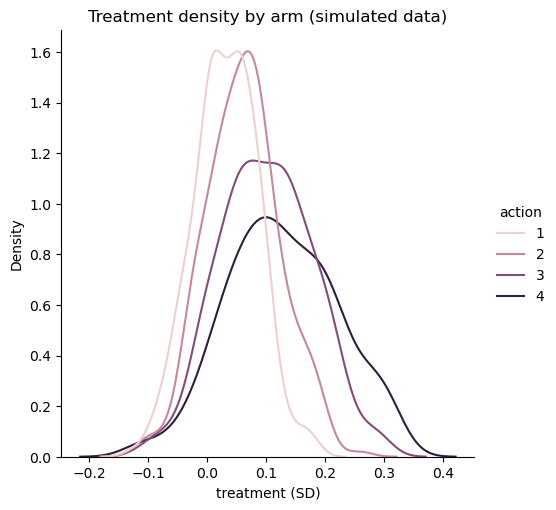

In [14]:
dfcb['treat']=-dfcb['treat']
df=dfcb
df['treat']=-df['treat']
fig1 = sns.displot(data = df, x='treat', kind='kde', hue='action').set(title='Treatment density by arm (simulated data)', xlabel="treatment (SD)")

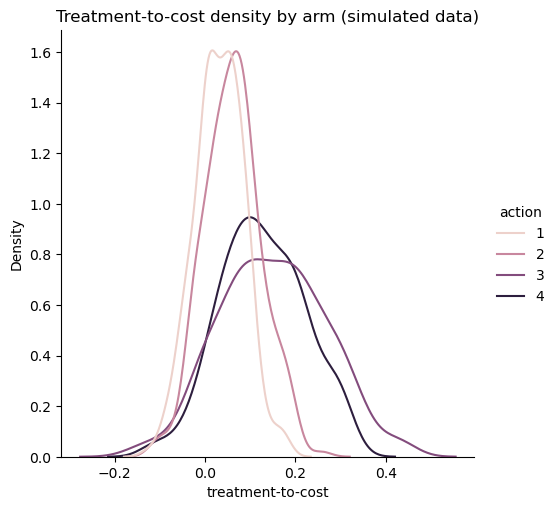

In [15]:
sns.displot(data = df, x='cet', kind='kde', hue='action').set(title='Treatment-to-cost density by arm (simulated data)', xlabel= "treatment-to-cost")

In [16]:
#construct data for estimation
train_df = dfcb[dfcb.index < 700]
test_df = dfcb[dfcb.index >= 700]
test_df.reset_index
X_train=train_df.drop(columns=['cet', 'user_id'], axis=1, inplace=False)
X_train2=train_df.drop(columns=['user_id','treat'], axis=1, inplace=False)

In [17]:
reg = smf.ols(formula="treat ~ s0 + i0 + educ + gender + mage + village + C(action)", data=X_train).fit()
reg2 = smf.ols(formula="cet ~ s0 + i0 + educ + gender + mage + village + C(action)", data=X_train2).fit()
print(reg2.summary())


                            OLS Regression Results                            
Dep. Variable:                    cet   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     36.77
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           2.63e-53
Time:                        15:42:09   Log-Likelihood:                 763.90
No. Observations:                 700   AIC:                            -1508.
Df Residuals:                     690   BIC:                            -1462.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0619      0.022      2.

In [18]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |user user:{} s0:{} i0:{} village{} educ:{} gender:{} mage:{}\n".format(
        context["user"], context["s0"], context["i0"], context["village"], context["educ"], context["gender"], context["mage"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|treat arm={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [19]:
def get_cost(s0, i0, action, village, educ, gender, mage, reg):
    usuario=pd.DataFrame({'s0':s0, 'i0':i0, 'action':action, 'village':village, 'educ':educ, 'gender':gender, 'mage':mage}, index=[0])
    costo=reg.predict(usuario)
    costo[0] = -costo[0] - random.gauss(0,0.05)
    return costo[0]

In [20]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [21]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [22]:
def run_simulation(num_iterations, dfcb, actions, cost_function, reg, do_learn = True):
    out = {
        'user_id': list(),
        'iteration': list(),
        'educ': list(),
        'gender': list(),
        'action': list(),
        'prob': list(),
        'cost': list(),
        'cost_sum': list()
    }
    
    for j in range(len(dfcb)):
        vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --rnd 3 --epsilon 0.025")
        cost_sum = 0.0
        for i in range(1, num_iterations+1):
            user = dfcb.iloc[j]['user_id']
            gender=dfcb.iloc[j]['gender']
            mage=dfcb.iloc[j]['mage']
            s0=dfcb.iloc[j]['s0']
            i0=dfcb.iloc[j]['i0']
            educ=dfcb.iloc[j]['educ']
            village=dfcb.iloc[j]['village']
            context = {"user": user, "s0": s0, "i0":i0, "village":village, "educ":educ, "gender":gender, "mage":mage}
            action, prob = get_action(vw, context, actions)
            # 4. Get cost of the action we chose
            cost = cost_function(s0, i0, action, village, educ, gender, mage, reg)
            cost = cost + i/1000 - (i*i)/100000    
            example = to_vw_example_format(context, actions, (action, cost, prob))
            if do_learn:
                vw_format = vw.parse(example, vowpalwabbit.LabelType.CONTEXTUAL_BANDIT,)
                vw.learn(vw_format)
            cost_sum += cost 
            out['user_id'].append(j),
            out['iteration'].append(i),
            out['educ'].append(educ),
            out['gender'].append(gender),
            out['action'].append(action),
            out['prob'].append(prob),
            out['cost'].append(cost),
            out['cost_sum'].append(cost_sum / i)
    return out

In [23]:
# Instantiate learner in VW
num_iterations = 24
dfcb=dfcb[dfcb.index < 800]
out  = run_simulation(num_iterations, dfcb, actions, get_cost, reg)

In [24]:
out2  = run_simulation(num_iterations, dfcb, actions, get_cost, reg2)

In [25]:
out = pd.DataFrame.from_dict(out, orient='columns')
out['cost']=-out['cost']
out['cost_sum']=-out['cost_sum']
out.describe()

,user_id,iteration,educ,gender,action,prob,cost,cost_sum
count,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000
mean,399.500000,12.500000,2.393750,0.793750,2.651719,0.265897,0.076685,0.079127
std,230.945942,6.922367,1.011812,0.404623,1.113910,0.068850,0.066155,0.035129
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.046108,-0.159972,-0.136415
25%,199.750000,6.750000,2.000000,1.000000,2.000000,0.223444,0.031952,0.056946
50%,399.500000,12.500000,2.000000,1.000000,3.000000,0.250565,0.076554,0.079339
75%,599.250000,18.250000,3.000000,1.000000,4.000000,0.302894,0.122708,0.102312
max,799.000000,24.000000,4.000000,1.000000,4.000000,0.739834,0.341287,0.294186


In [26]:
pd.pivot_table(out, values='cost', index=['action'], columns=['iteration'], aggfunc='mean')

iteration,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
action,,,,,,,,,,,,,,,,,,,,,
1,0.037085,0.038698,0.034104,0.033970,0.034529,0.030980,0.029591,0.025002,0.033217,0.021954,...,0.023713,0.021549,0.021782,0.013829,0.028851,0.018812,0.020025,0.018672,0.020777,0.026326
2,0.064579,0.061814,0.058130,0.057204,0.057707,0.056573,0.057637,0.055576,0.057678,0.059663,...,0.052349,0.047182,0.053973,0.056113,0.056779,0.044144,0.047194,0.044835,0.046790,0.042296
3,0.105375,0.098010,0.099782,0.095325,0.086807,0.094506,0.092135,0.092709,0.088906,0.089709,...,0.087059,0.090855,0.094181,0.086131,0.079235,0.088123,0.082538,0.076045,0.085955,0.086880
4,0.125855,0.121751,0.121934,0.127631,0.121819,0.119983,0.125205,0.115981,0.120509,0.123266,...,0.109895,0.116678,0.117777,0.114181,0.114161,0.116684,0.109014,0.117481,0.114083,0.109572


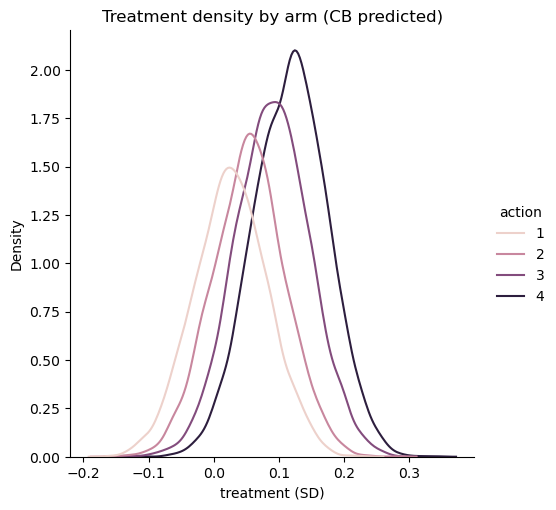

In [27]:
sns.displot(data = out, x='cost', kind='kde', hue='action').set(title='Treatment density by arm (CB predicted)', xlabel="treatment (SD)")

In [28]:
out2 = pd.DataFrame.from_dict(out2, orient='columns')
out2['cost']=-out2['cost']
out2['cost_sum']=-out2['cost_sum']
out2.describe()

,user_id,iteration,educ,gender,action,prob,cost,cost_sum
count,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000
mean,399.500000,12.500000,2.393750,0.793750,2.683281,0.272875,0.093791,0.095160
std,230.945942,6.922367,1.011812,0.404623,1.078777,0.080037,0.073935,0.039362
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.064133,-0.204427,-0.101496
25%,199.750000,6.750000,2.000000,1.000000,2.000000,0.221372,0.042833,0.070275
50%,399.500000,12.500000,2.000000,1.000000,3.000000,0.255180,0.096168,0.095951
75%,599.250000,18.250000,3.000000,1.000000,4.000000,0.320977,0.145684,0.120485
max,799.000000,24.000000,4.000000,1.000000,4.000000,0.726776,0.361779,0.324968


In [29]:
pd.pivot_table(out, values='cost', index=['gender', 'educ'], columns=['action'], aggfunc='mean')

action              1         2         3         4
gender educ                                        
0.0    1.0  -0.021305  0.011439  0.049986  0.070924
       2.0  -0.006565  0.022179  0.053844  0.087456
       3.0   0.005287  0.036712  0.073200  0.099694
       4.0   0.017613  0.053027  0.085190  0.111755
1.0    1.0   0.014952  0.041783  0.078891  0.107587
       2.0   0.027448  0.054856  0.091825  0.118169
       3.0   0.039557  0.070234  0.106601  0.132953
       4.0   0.057722  0.080944  0.116105  0.146709

In [30]:
pd.pivot_table(out, values='cost', index=['action'], columns=['iteration'], aggfunc='count')

iteration,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
action,,,,,,,,,,,,,,,,,,,,,
1,208,192,206,192,170,168,183,183,181,178,...,178,160,159,146,160,177,164,143,134,133
2,183,189,198,158,188,178,176,191,181,166,...,196,176,189,183,173,162,164,163,162,192
3,206,216,186,215,225,234,216,200,196,227,...,201,222,210,213,207,222,219,216,233,229
4,203,203,210,235,217,220,225,226,242,229,...,225,242,242,258,260,239,253,278,271,246


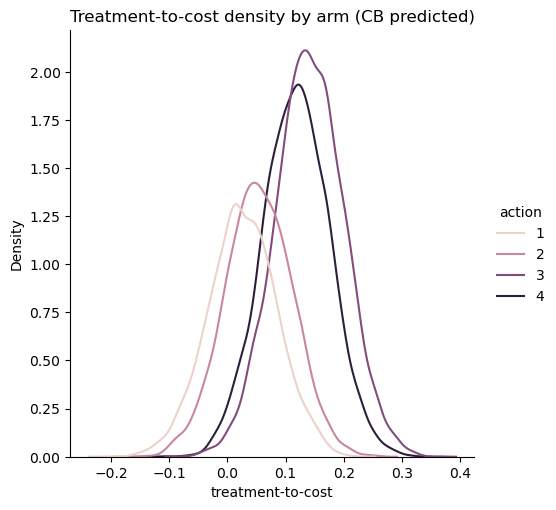

In [31]:
sns.displot(data = out2, x='cost', kind='kde', hue='action').set(title='Treatment-to-cost density by arm (CB predicted)', xlabel="treatment-to-cost")

[Text(0.5, 1.0, 'Mean cummulative treatment effect by arm per period'),
 Text(0, 0.5, 'treatment (SD)')]

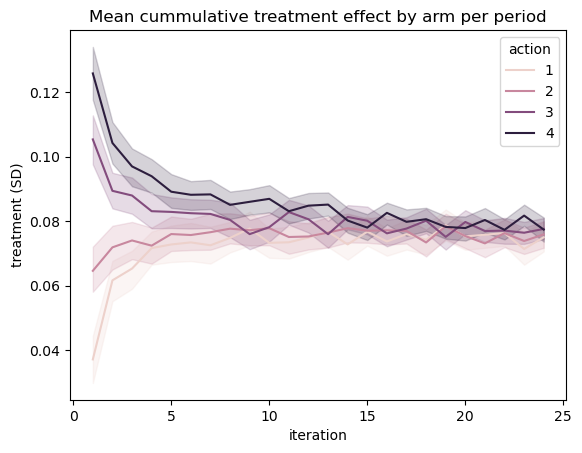

In [32]:
sns.lineplot(data=out, x='iteration', y='cost_sum', hue='action').set(title='Mean cummulative treatment effect by arm per period', ylabel="treatment (SD)")

[Text(0.5, 1.0, 'Predicted probability by arm per period (treatment)')]

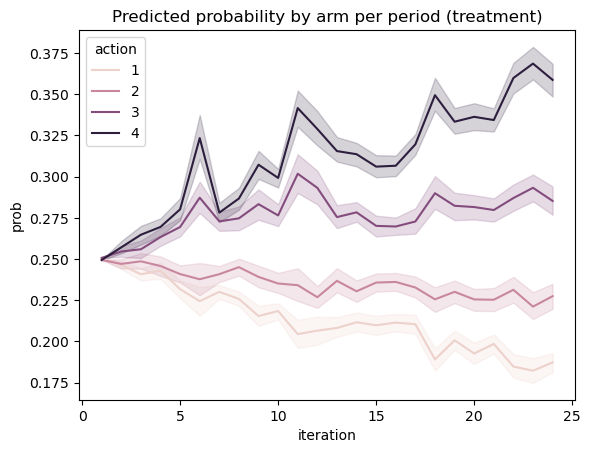

In [33]:
sns.lineplot(data=out, x='iteration', y='prob', hue='action').set(title='Predicted probability by arm per period (treatment)')

[Text(0.5, 1.0, 'Predicted probability by arm per period (treatment-to-cost ratio)')]

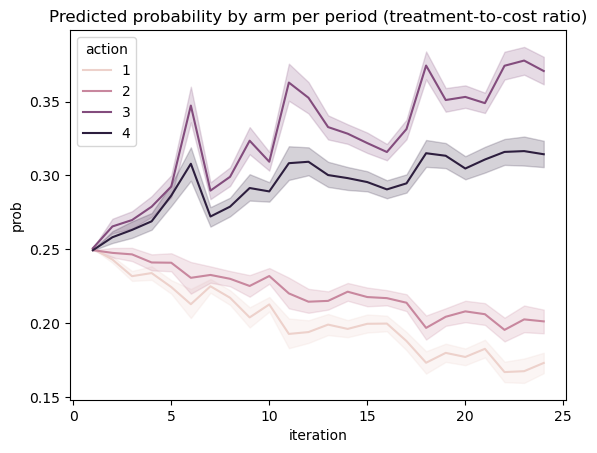

In [34]:
sns.lineplot(data=out2, x='iteration', y='prob', hue='action').set(title='Predicted probability by arm per period (treatment-to-cost ratio)')

[Text(0.5, 1.0, 'Average treatment effect by arm (last period)'),
 Text(0, 0.5, 'treatment (SD)')]

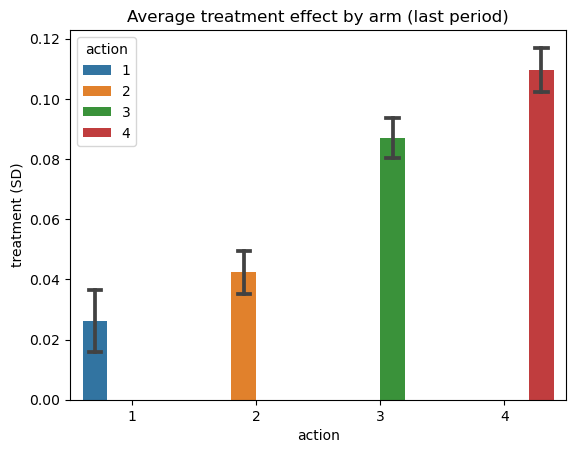

In [38]:
sns.barplot(data=out[out.iteration == 24], x='action', y='cost', hue='action', errorbar=('ci'), capsize=.1).set(title='Average treatment effect by arm (last period)', ylabel="treatment (SD)")

[Text(0.5, 1.0, 'Average treatment-to-cost effect by arm (last period)'),
 Text(0, 0.5, 'treatment-to-cost')]

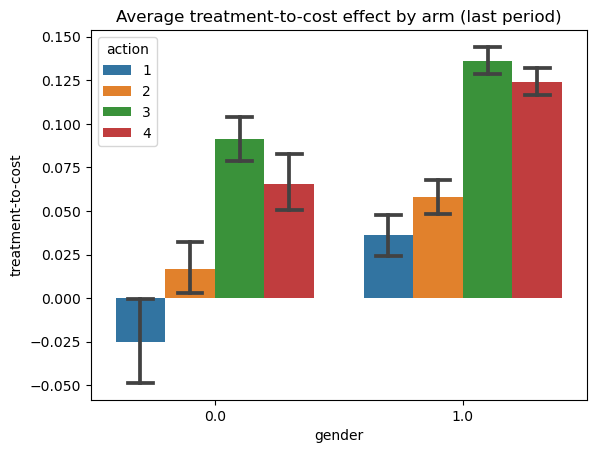

In [39]:
sns.barplot(data=out2[out2.iteration == 24], x='gender', y='cost', hue='action', errorbar=('ci'), capsize=.1).set(title='Average treatment-to-cost effect by arm (last period)', ylabel="treatment-to-cost")